# Training A2C Agent on Snake using Jumanji API
This notebook is an example of how to use the Jumanji API to train a Deep-RL agent. We will train an A2C agent on the `"Snake-v1"` Jumanji environment under the Anakin framework. The Anakin design was developed by Matteo Hessel, Manuel Kroiss, Fabio Viola and Hado van Hasselt in [Podracer architectures for scalable Reinforcement Learning](https://arxiv.org/abs/2104.06272).

**Aims:**
* Understand the basics of the Jumanji API.
* Solve the `"Snake-v1"` environment with A2C under the Anakin framework.

**Prerequisites:**
* Familiarity with [JAX](https://jax.readthedocs.io/en/latest/beginner_guide.html#beginner-guide).
* Understanding of the [A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f) algorithm 

## Install and Import

In [1]:
%%capture
! pip3 install -U pip

# if using a GPU
! pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# if using a TPU 
#! pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html # tpu

! pip install jaxlib
! pip3 install dm-haiku
! pip3 install optax 
! pip3 install matplotlib
! pip3 install jumanji
! pip3 install tensorflow
! pip3 install tensorrt
! pip3 install chex
! pip3 install rlax
! pip3 install tqdm
! pip3 install distrax

In [1]:
# ensure GPU is not preallocating space
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

import jax
import warnings

accelerator_type = jax.devices()[0].platform

if accelerator_type == 'tpu':
    # setup TPU
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print("Running with TPU!")

elif accelerator_type == "gpu":
    print("Running with GPU!")

else:
    print("Running with CPU!")
    warnings.warn(
        "Running with CPU. We reccomend running this notebook in Colab with TPU enabled,"
        "or GPU if TPU is not available."
    )

import jax.numpy as jnp
import jaxlib
from jax.lib import xla_bridge
from jax import lax
import tensorrt
import tensorflow as tf

import haiku as hk
import optax
import rlax
import distrax
import timeit
import chex
import functools

import numpy as np
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from typing import Sequence, Tuple, Callable, Any

import jumanji
from jumanji.wrappers import AutoResetWrapper
from jumanji.environments.routing.snake import State, Observation, Snake
from jumanji.environments import Snake
from jumanji.types import TimeStep

# prevent TensorFlow from allocating GPU memory
tf.config.set_visible_devices([], "GPU")

# for VScode output
%matplotlib inline

Running with GPU!


## Basic usage of Jumanji
We implement a 10 step episode to illustrate the basic usage of a Jumanji environment. 

In [2]:
# initialise environment
env = jumanji.make("Snake-v1")
num_actions = env.action_spec().num_values

# generate PRNG key for randomness
key = jax.random.PRNGKey(0)

# reset the environment and receive the initial state and timestep
state, timestep = env.reset(key)

# jit environment step function
env_step = jax.jit(env.step)

# run episode for 10 steps
done = False
transitions = 0
while not done and transitions < 10:
    # generate new key
    key, _ = jax.random.split(key)

    # select action randomly
    action = jax.random.randint(key, (), 0, num_actions)

    # transition to next state
    state, timestep = env_step(state, action)
    transitions += 1

    # validate action
    done = not timestep.discount

    # render environment
    env.render(state)

env.close()


## Networks and Policy
##### Here, we define the architectures of the actor and critic networks and get their output for some `dummy_observation`.

In [3]:
def expand_obs_dims(observation: Observation, axis=0):
    """Expands the dimensions of an observation"""
    expand = lambda x: jnp.expand_dims(x, axis=axis)
    new_observation = jax.tree_util.tree_map(expand, observation)

    return new_observation

In [15]:
def make_snake_cnn(
    num_outputs: int,
    mlp_units: Sequence[int]=(64, 64),
    conv_n_channels: int=32,
    time_limit: int=500,
):
    """Builds and returns a network comprised of a CNN and FFN"""
    def network_fn(observation: Observation) -> chex.Array:
        torso = hk.Sequential(
            [
                hk.Conv2D(conv_n_channels, (2, 2), 2),
                jax.nn.relu,
                hk.Conv2D(conv_n_channels, (2, 2), 1),
                jax.nn.relu,
                hk.Flatten(),
            ]
        )
        embedding = torso(observation.grid)
        norm_step_count = jnp.expand_dims(observation.step_count / time_limit, axis=-1)
        embedding = jnp.concatenate([embedding, norm_step_count], axis=-1)
        head = hk.nets.MLP((*mlp_units, num_outputs), activate_final=False)
        if num_outputs == 1:
            value = jnp.squeeze(head(embedding), axis=-1)
            return value
        else:
            logits = head(embedding)
            logits = jnp.where(
                observation.action_mask, logits, jnp.finfo(jnp.float32).min
            )
            return logits

    return hk.without_apply_rng(hk.transform(network_fn))

Initialise the actor and critic networks.

In [5]:
# initialise and reset environment 
env = Snake(num_rows=6, num_cols=6, time_limit=500)
key = jax.random.PRNGKey(0)
_, dummy_timestep = env.reset(key)

# build actor and critic networks
actor = make_snake_cnn(mlp_units=(64, 64), num_outputs=env.action_spec().num_values)
critic = make_snake_cnn(mlp_units=(128, 128), num_outputs=1)

# initial networks with a dummy observation
init_actor_params = actor.init(key, expand_obs_dims(dummy_timestep.observation, axis=0))
init_critic_params = critic.init(key, expand_obs_dims(dummy_timestep.observation, axis=0))

Create a policy from the actor network and parameters.

In [20]:
def make_policy(
        policy_params: hk.Params,
        policy_network: hk.transform,
        stochastic: bool = True,
        ) -> Callable:
        """Builds and returns a callable policy from a network and parameters"""
        def policy(
            observation: Any, key: chex.PRNGKey
        ) -> Tuple[chex.Array, Tuple[chex.Array, chex.Array]]:
            
            logits = policy_network.apply(policy_params, expand_obs_dims(observation))[0]

            if stochastic:
                temperature = 1
            else:
                temperature = 0

            action = rlax.softmax(temperature=temperature).sample(key, logits)
            logprob = rlax.softmax(temperature=temperature).logprob(sample=action, logits=logits)
            return action, (logprob, logits)

        return policy

Print the output of both the policy (actor) and value (critic) networks

In [30]:
# jit methods
policy = jax.jit(make_policy(init_actor_params, actor))
value = jax.jit(critic.apply)

# get outputs on dummy observation
# policy (actor)
action, (logprob, logits) = policy(
    dummy_timestep.observation, key
)
# critic
value = value(init_critic_params, expand_obs_dims(dummy_timestep.observation, axis=0))[0]

print("action  :", action)
print("logprob :", logprob)
print("logits  :", *logits)
print("value   :", value)

env.close()

action  : 0
logprob : -1.1176364
logits  : -0.003755798 0.026366562 -3.4028235e+38 0.022923257
value   : -0.011857377


## Anakin Framework
The majority of the code below is copied verbatim from the [Podracer Architectures for Scalable RL](https://colab.research.google.com/drive/1974D-qP17fd5mLxy6QZv-ic4yxlPJp-G?usp=sharing#scrollTo=mGSmAiCHJsas).

**Additions**
* Record training metrics such as mean episode return and loss per batch.
* An evaluation step per batch.

Define useful containers.

In [9]:
class TimeIt:
    def __init__(self, tag, frames=None):
        self.tag = tag
        self.frames = frames

    def __enter__(self):
        self.start = timeit.default_timer()
        return self

    def __exit__(self, *args):
        self.elapsed_secs = timeit.default_timer() - self.start
        msg = self.tag + (": Elapsed time=%.2fs" % self.elapsed_secs)
        if self.frames:
            msg += ", FPS=%.2e" % (self.frames / self.elapsed_secs)
        print(msg)


@chex.dataclass(frozen=True)
class Experience:
    """Contains all information of one experience of the agent"""

    observation: chex.Array
    action: chex.Array
    logprob: chex.Array
    logits: chex.Array
    discount: chex.Array
    reward: chex.Array
    
@chex.dataclass(frozen=True)
class EpisodeMetrics:
    """Metrics that we use to keep track of the episode return and length
    throughout interation with the environment."""

    episode_return: chex.Array
    episode_length: chex.Array


@chex.dataclass(frozen=True)
class Parameters:
    """Contains actor and critic parameters"""
    actor: hk.Params
    critic: hk.Params

@chex.dataclass(frozen=True)
class LearningRates:
    """Contains the coefficients for actor, critic and entropy terms"""
    policy: chex.Array
    td: chex.Array
    ent: chex.Array


Define policy evaluation method.

In [22]:
def get_evaluator(
    policy_network: Callable,
    eval_env_reset: Callable,
    eval_env_step: Callable,
    eval_batch_size: int = 10,
):
    """Builds and returns method to evaluate currently policy"""
    def evaluate(params: hk.Params, key: chex.PRNGKey):
        policy = make_policy(params, policy_network)
        def evaluate_one_episode(key: chex.PRNGKey):
            def one_step(
                state: State,
                timestep: TimeStep,
                key: chex.PRNGKey,
                return_: chex.Numeric,
            ):
                key, act_key = jax.random.split(key)
                action, _ = policy(timestep.observation, act_key)
                state, timestep = eval_env_step(state, action)
                return_ += timestep.reward

                return state, timestep, key, return_

            # reset environment and execute a single episode
            key, reset_key = jax.random.split(key)
            state, timestep = eval_env_reset(reset_key)
            *_, return_ = jax.lax.while_loop(
                lambda carry: ~carry[1].last(),
                lambda carry: one_step(*carry),
                (state, timestep, key, jnp.array(0, float)),
            )
            return return_

        # vmap to evaluate over batch of episodes
        keys = jax.random.split(key, eval_batch_size)
        returns = jax.vmap(evaluate_one_episode)(keys)
        return jnp.mean(returns)

    return evaluate

### Define Learner Function

The method `get_learner_fn` returns a method `learner_fn` which:
* Collects a batch of experiences from a trajectory while recording any useful information. 
* Computes the squared TD($\lambda$) loss of the batch of experiences.
* Computes the gradient of the loss with respect to the network's parameters.
* Aggregates the gradient across a batch of trajectories, and across multiple devices (if using TPU).
* Updates the network's parameters with the Adam optimizer.
* Runs this update step multiple times without going back to python. The original Anakin implementation uses `jax.lax.fori` however we would like to obtain information from each step of the algoirthm. Therefore, we use `jax.lax.scan`.

In [36]:
def get_learner_fn(
    env_step: Callable,
    policy_network: Callable,
    value_apply: Callable,
    opt_update: Callable,
    rollout_len: int,
    agent_discount: float,
    iterations: int,
    bootstrap_factor: float,
    lrs: LearningRates,
):
    """Define the minimal unit of computation in Anakin."""

    def loss_fn(
        params: Parameters,
        outer_key: chex.PRNGKey,
        env_state: State,
        env_timestep: TimeStep,
        episode_metrics: EpisodeMetrics,
    ):
        """Compute the loss on a single trajectory."""

        policy = jax.jit(make_policy(params.actor, policy_network))


        def step_fn(carry, key: chex.PRNGKey):
            env_state, env_timestep, episode_metrics = carry

            action, (logprob, logits) = policy(
                env_timestep.observation, key
            )
            
            next_env_state, next_env_timestep = env_step(env_state, action)
            reward = next_env_timestep.reward
            discount = next_env_timestep.discount

            info = {
                "episode_return": jnp.where(
                    discount == 0.0, reward + episode_metrics.episode_return, jnp.nan
                ),
                "episode_length": jnp.where(
                    discount == 0.0, 1 + episode_metrics.episode_length, jnp.nan
                ),
            }

            episode_metrics = EpisodeMetrics(
                episode_return=jnp.where(
                    discount == 0.0,
                    jnp.array(0.0),
                    reward + episode_metrics.episode_return,
                ),
                episode_length=jnp.where(
                    discount == 0.0, jnp.array(0), 1 + episode_metrics.episode_length
                ),
            )

            carry = next_env_state, next_env_timestep, episode_metrics
            return carry, (
                Experience(
                    observation=env_timestep.observation,
                    action=action,
                    logprob=logprob,
                    logits=logits,
                    discount=discount,
                    reward=reward,
                ),
                info,
            )

        # trajectory
        step_keys = jax.random.split(outer_key, rollout_len)
        (env_state, env_timestep, episode_metrics), (rollout, info) = lax.scan(
            step_fn, (env_state, env_timestep, episode_metrics), step_keys
        )

        value = jax.vmap(value_apply, in_axes=(None, 0))(params.critic, expand_obs_dims(rollout.observation))
        value = jnp.reshape(value, (value.shape[-1], value.shape[-2]))

        discounts = jnp.asarray(agent_discount * rollout.discount, float)
        value_tm1 = value[:-1]
        value_t = value[1:]
        r_t = jnp.expand_dims(rollout.reward[:-1], axis=1)
        discount_t = jnp.expand_dims(discounts[:-1], axis=1)

        batch_td_lambda = jax.vmap(functools.partial(rlax.td_lambda, lambda_=bootstrap_factor, stop_target_gradients=True), in_axes=0)
        advantage = batch_td_lambda(
            v_tm1=value_tm1,
            r_t= r_t,
            discount_t = discount_t,
            v_t=value_t,    
        )

        critic_loss = jnp.mean(advantage**2)
        policy_loss = -jnp.mean(jax.lax.stop_gradient(advantage) * rollout.logprob)
        
        entropy = jnp.mean(
            rlax.softmax(temperature=1).entropy(logits=rollout.logits)
        )
        entropy_loss = -entropy

        total_loss = (
            lrs.policy * policy_loss + lrs.td * critic_loss + lrs.ent * entropy_loss
        )

        # log info
        info = {
            "episode_return": jnp.nanmean(info["episode_return"], axis=0),
            "episode_length": jnp.nanmean(info["episode_length"], axis=0),
            "reward": jnp.mean(rollout.reward),
            "max_episode_return": jnp.nanmax(info["episode_return"], axis=0),
            "loss": jnp.array([total_loss]),
        }

        return total_loss, (env_state, env_timestep, episode_metrics, info)

    def update_fn(
        parameters: Parameters,
        opt_state: Tuple,
        key: chex.PRNGKey,
        env_state: State,
        env_timestep: TimeStep,
        episode_metrics: EpisodeMetrics,
    ):
        """Compute a gradient update from a single trajectory."""

        # compute grad for single trajectory
        key, loss_key = jax.random.split(key)

        grads, (
            new_env_state,
            new_env_timestep,
            episode_metrics,
            info,
        ) = jax.grad(loss_fn, has_aux=True)(
            parameters,
            loss_key,
            env_state,
            env_timestep,
            episode_metrics,
        )

        # reduce mean across cores and batch
        grads = lax.pmean(grads, axis_name="j")
        grads = lax.pmean(grads, axis_name="i")

        # transform grads
        updates, new_opt_state = opt_update(grads, opt_state)

        new_parameters = optax.apply_updates(parameters, updates)

        return (
            new_parameters,
            new_opt_state,
            key,
            new_env_state,
            new_env_timestep,
            episode_metrics,
            info,
        )

    def learner_fn(
        parameters: Parameters,
        opt_state: Tuple,
        keys: chex.PRNGKey,
        env_states: State,
        env_timesteps: TimeStep,
        episode_metrics: EpisodeMetrics,
    ):
        """Vectorise and repeat the update."""
        # vectorize across batch
        batched_update_fn = jax.vmap(update_fn, axis_name="j")

        def iterate_fn(carry, _):
            (
                parameters,
                opt_state,
                keys,
                env_states,
                env_timesteps,
                episode_metrics,
            ) = carry

            (
                new_parameters,
                new_opt_state,
                keys,
                new_env_state,
                new_env_timestep,
                episode_metrics,
                info,
            ) = batched_update_fn(
                parameters,
                opt_state,
                keys,
                env_states,
                env_timesteps,
                episode_metrics,
            )


            carry = (
                new_parameters,
                new_opt_state,
                keys,
                new_env_state,
                new_env_timestep,
                episode_metrics,
            )

            # update info
            max_return_info = {
                "max_episode_return": jnp.nanmax(info["max_episode_return"], axis=0)
            }

            info = jax.tree_util.tree_map(lambda x: jnp.nanmean(x, axis=0), info)
            info.update(max_return_info)

            return carry, info

        init = (
            parameters,
            opt_state,
            keys,
            env_states,
            env_timesteps,
            episode_metrics,
        )

        return jax.lax.scan(iterate_fn, init, xs=None, length=iterations)

    return learner_fn


### Define experiment

Given a set of hyper-parameters, `run_experiment` initialises and executes the experiment. The experiement runs multiped pmapped iterations of `learner_fn` until the desired number of total training iterations is reached. `run_experiment` returns the recorded training information, the most recently updated network parameters and the best evaluation score.

In [41]:
def run_experiment(
    env,
    eval_env,
    batch_size: int,
    rollout_len: int,
    step_size: float,
    iterations: int,
    discount_factor: float,
    seed: int,
    bootstrap_factor: float,
    lrs: LearningRates, 
):
    """Runs experiment"""

    # generate prng keys
    key, env_key, actor_init_key, critic_init_key, eval_key, dummy_key = jax.random.split(
        jax.random.PRNGKey(seed), num=6
    )

    # get available TPU cores
    cores_count = len(jax.devices())

    # get dummy observation
    _, dummy_timestep = env.reset(dummy_key)

    # build DQN and get dummy q-values
    actor = make_snake_cnn(mlp_units=(64, 64), num_outputs=env.action_spec().num_values, time_limit=5000)
    critic = make_snake_cnn(mlp_units=(128, 128), num_outputs=1, time_limit=5000)

    # initial DQN with a dummy observation
    init_actor_params = actor.init(actor_init_key, expand_obs_dims(dummy_timestep.observation, axis=0))
    init_critic_params = critic.init(critic_init_key, expand_obs_dims(dummy_timestep.observation, axis=0))


    parameters = Parameters(actor=init_actor_params, critic=init_critic_params)

    # define and initialise optimiser
    optim = optax.adam(step_size)
    opt_state = optim.init(parameters)

    inner_iter_length = 100

    # jitables
    env_step = jax.jit(env.step)
    value_apply = jax.jit(critic.apply)
    eval_env_reset = jax.jit(eval_env.reset)
    eval_env_step = jax.jit(eval_env.step)

    # get learner method
    learn = get_learner_fn(
        env_step=env_step,
        policy_network=actor,
        value_apply=value_apply,
        opt_update=optim.update,
        rollout_len=rollout_len,
        agent_discount=discount_factor,
        iterations=inner_iter_length,
        bootstrap_factor=bootstrap_factor,
        lrs=lrs,
    )

    # replicate over multiple cores
    learn = jax.pmap(learn, axis_name="i")

    # get evaluation method
    evaluate = jax.jit(
        get_evaluator(
            policy_network=actor,
            eval_env_reset=eval_env_reset,
            eval_env_step=eval_env_step,
        )
    )

    # define episode metrics
    episode_metrics = EpisodeMetrics(
        episode_return=jnp.zeros(shape=(), dtype=jnp.float32),
        episode_length=jnp.zeros(shape=(), dtype=jnp.int16),
    )

    # broadcast to cores and batch
    broadcast = lambda x: jnp.broadcast_to(x, (cores_count, batch_size) + x.shape)

    opt_state = jax.tree_map(broadcast, opt_state)
    parameters = jax.tree_map(broadcast, parameters)
    episode_metrics = jax.tree_map(broadcast, episode_metrics)

    # get intial states
    env_key, *env_keys = jax.random.split(env_key, cores_count * batch_size + 1)
    env_states, env_timesteps = jax.vmap(env.reset)(jnp.stack(env_keys))

    key, *step_keys = jax.random.split(key, cores_count * batch_size + 1)

    reshape = lambda x: jax.tree_util.tree_map(
        lambda x: x.reshape((cores_count, batch_size) + x.shape[1:]), x
    )

    # add dimension to pmap over
    step_keys = reshape(jnp.stack(step_keys))
    env_states = reshape(env_states)
    env_timesteps = reshape(env_timesteps)

    best_score = 0

    # compile
    num_frames_compile = cores_count * inner_iter_length * rollout_len * batch_size
    with TimeIt(tag="COMPILATION", frames=num_frames_compile):
        learn(
            parameters,
            opt_state,
            step_keys,
            env_states,
            env_timesteps,
            episode_metrics,
        )

    # execute mulitple training iterations
    num_frames = cores_count * iterations * rollout_len * batch_size
    n_outer_iter = int(iterations // inner_iter_length)
    with TimeIt(tag="EXECUTION", frames=num_frames):
        for i in tqdm(range(n_outer_iter)):
            (
                parameters,
                opt_state,
                step_keys,
                env_states,
                env_timesteps,
                episode_metrics,
            ), new_info = learn(
                parameters,
                opt_state,
                step_keys,
                env_states,
                env_timesteps,
                episode_metrics,
            )

            # update info
            max_return_info = {
                "max_episode_return": jnp.nanmax(new_info["max_episode_return"], axis=0)
            }

            new_info = jax.tree_util.tree_map(
                lambda x: jnp.nanmean(x, axis=0), new_info
            )
            new_info.update(max_return_info)

            # evaluate and add to info
            params_single_device = jax.tree_util.tree_map(
                lambda x: x[0, 0], parameters.actor
            )

            eval_key, eval_subkey = jax.random.split(eval_key)
            eval_return = evaluate(params_single_device, eval_subkey)

            if eval_return >= best_score:
                best_score = eval_return

            additional_info = {
                "eval_return": jnp.array([eval_return]),
            }
            new_info.update(additional_info)

            if i == 0:
                info = new_info
            else:
                info = {
                    dict_key: jnp.concatenate((info[dict_key], new_info[dict_key]))
                    for dict_key in info.keys()
                }

    params_single_device = jax.tree_util.tree_map(lambda x: x[0, 0], parameters.actor)
    return info, params_single_device, best_score


### Run Experiment and Visualise Results 
We initial the environments, choose our set of hyper-parameters and call `run_experiment()`.

In [42]:
# env = AutoResetWrapper(Snake(num_rows=6, num_cols=6, time_limit=500))
# eval_env = Snake(num_rows=6, num_cols=6, time_limit=500)
env = AutoResetWrapper(jumanji.make("Snake-v1"))
eval_env = jumanji.make("Snake-v1")

info, params, best_score = run_experiment(env, eval_env, batch_size=128, rollout_len=20, step_size=3e-4, iterations=15000, discount_factor=0.997, seed=8, bootstrap_factor=0.95, lrs=LearningRates(policy=1.0, td=1.0, ent=0.01))

env.close()
eval_env.close()

print("Best evaluation score: ", best_score)

4000
COMPILATION: Elapsed time=4.56s, FPS=5.61e+04


KeyboardInterrupt: 

#### Plot Results

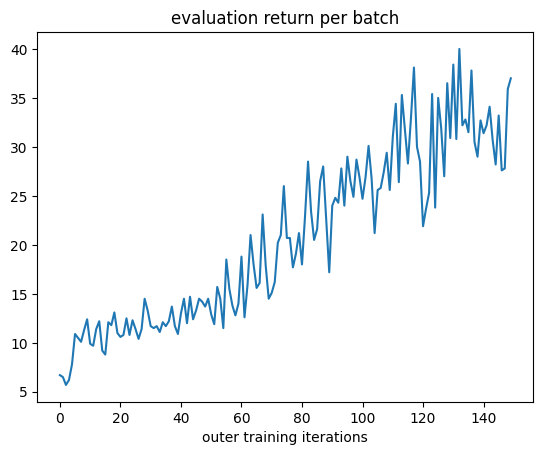

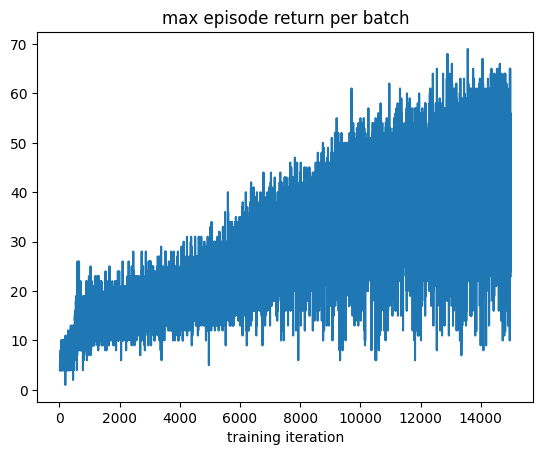

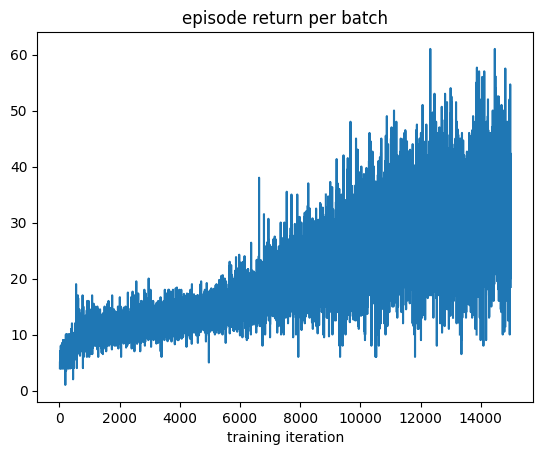

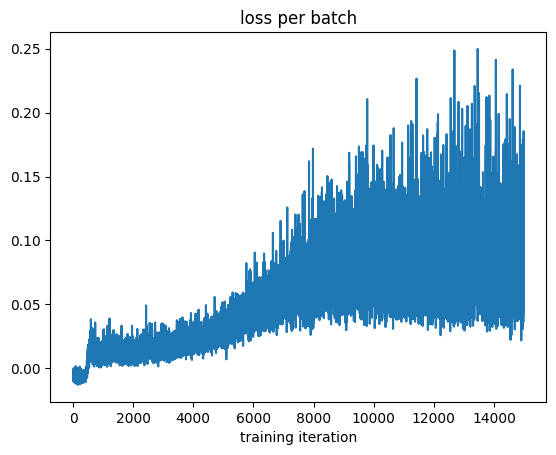

In [40]:
plt.plot(info["eval_return"])
plt.title("evaluation return per batch")
plt.xlabel("outer training iterations")
plt.show()

plt.plot(info["max_episode_return"])
plt.title("max episode return per batch")
plt.xlabel("training iteration")
plt.show()

plt.plot(info["episode_return"])
plt.title("episode return per batch")
plt.xlabel("training iteration")
plt.show()

plt.plot(info["loss"])
plt.title("loss per batch")
plt.xlabel("training iteration")
plt.show()


## Rollout Agent
We let the agent rolllout for an episode and visualise its behaviour.


In [34]:
key = jax.random.PRNGKey(0)

env = Snake(num_rows=6, num_cols=6, time_limit=500)
state, timestep = env.reset(key)

actor = make_snake_cnn(num_outputs=env.action_spec().num_values)
policy = make_policy(params, actor)

done = False
transitions = 0
while not done:
    # select action greedily
    key, act_key = jax.random.split(key)
    action, _ = policy(timestep.observation, act_key)

    # take a step in the environment
    state, timestep = env.step(state, action)
    transitions += 1

    done = not timestep.discount

    env.render(state)

env.close()


## Conclusion

This notebook serves as an illustrative example of the Jumanji API's functionality. Its purpose is to provide an overview of the API's basic usage, demonstrate the training of a deep-RL agent using the Anakin Framework and visualise a single episode's rollout. We hope this has been a valuable resource in acquainting you with the fundamentals of the Jumanji API. For a detailed understanding of the Jumanji API's capabilities and features, we invite you to take a look at the official [Jumanji documentation](https://instadeepai.github.io/jumanji/).

Goodluck with any of your research endeavours and don't forget to cite the library using:

```
@misc{bonnet2023jumanji,
    title={Jumanji: a Diverse Suite of Scalable Reinforcement Learning Environments in JAX},
    author={
        Clément Bonnet and Daniel Luo and Donal Byrne and Shikha Surana and Vincent Coyette and
        Paul Duckworth and Laurence I. Midgley and Tristan Kalloniatis and Sasha Abramowitz and
        Cemlyn N. Waters and Andries P. Smit and Nathan Grinsztajn and Ulrich A. Mbou Sob and
        Omayma Mahjoub and Elshadai Tegegn and Mohamed A. Mimouni and Raphael Boige and
        Ruan de Kock and Daniel Furelos-Blanco and Victor Le and Arnu Pretorius and
        Alexandre Laterre
    },
    year={2023},
    eprint={2306.09884},
    url={https://arxiv.org/abs/2306.09884},
    archivePrefix={arXiv},
    primaryClass={cs.LG}
}
```
